In [ ]:
import sys
from importlib import reload
from collections.abc import Callable

from matplotlib import pyplot as plt
from matplotlib import cm, colors

import numpy as np
import jax
from jax import numpy as jnp
from jax.numpy import fft

sys.path.append("..")
import base_system
import base_solver
import base_optim
import solvers
import utils

import wave_1d_fourier

reload(base_system)
reload(base_solver)
reload(base_optim)
reload(solvers)
reload(utils)

reload(wave_1d_fourier)

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values(x0: float, xf: float, n: int):
    """Get initial values for the true and nudged states.

    Parameters
    ----------
    x0, xf
        Endpoints of domain
    n
        Number of spatial grid points on [x0, xf]

    Returns
    -------
    u0
        Initial true state
    un0
        Initial nudged state
    """
    # Initial true state
    u = lambda x: np.array(
        [
            0.2 * jnp.exp(-10 * (x - 5) ** 2),
            -4 * (x - 5) * np.exp(-10 * (x - 5) ** 2),
        ]
    )
    xls = jnp.linspace(x0, xf, n)
    u0 = u(xls)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return fft.rfft(u0), fft.rfft(un0)


def plot(cs, u_errors, g, tls):
    num_iters = len(cs)
    ils = np.arange(num_iters)

    fig, axs = plt.subplots(1, 2, figsize=(10, 8))

    ax = axs[0]
    ax.hlines(g, ils[0], ils[-1], label="g", color="black")
    ax.plot(ils, cs, label="c")
    ax.legend()
    ax.set_title("c vs g")
    ax.set_xlabel("Iteration number")

    ax = axs[1]
    ax.plot(tls[1:], u_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $u$")
    ax.set_xlabel("Time")

    fig.tight_layout()

    return fig, axs

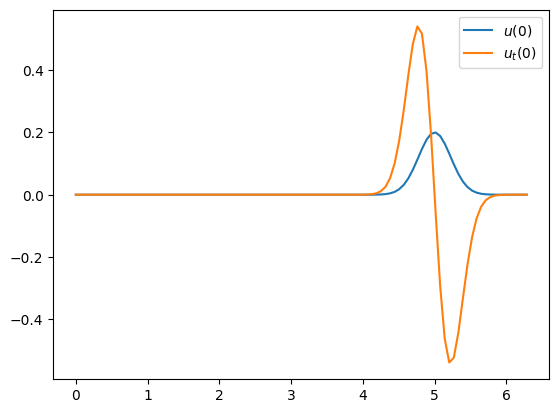

In [ ]:
# System evolution parameters
x0, xf = 0, 2 * np.pi
g = 1
c = g
c *= 0.5
μ = 1
xn = 100

gs = jnp.array([g], dtype=complex)
bs = jnp.array([])
cs = jnp.array([c], dtype=complex)

observed_slice = jnp.s_[:]
system = wave_1d_fourier.Wave(μ, gs, bs, cs, observed_slice, x0, xf, xn)
solver = solvers.RK4(system)
optimizer = base_optim.LevenbergMarquardt(system, 1e-1)

# Simulation parameters
dt = 0.04
T0, Tf = 0, 400
t_relax = 1

init = get_initial_values(x0, xf, xn)[0]
plt.plot(np.linspace(x0, xf, xn), fft.irfft(init[0]), label="$u(0)$")
plt.plot(np.linspace(x0, xf, xn), fft.irfft(init[1]), label="$u_t(0)$")
plt.legend()
plt.show()

return_all = True
cs, u_errors, tls, true, nudged = utils.run_update(
    system,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    *get_initial_values(x0, xf, xn),
    optimizer,
    return_all=return_all,
)

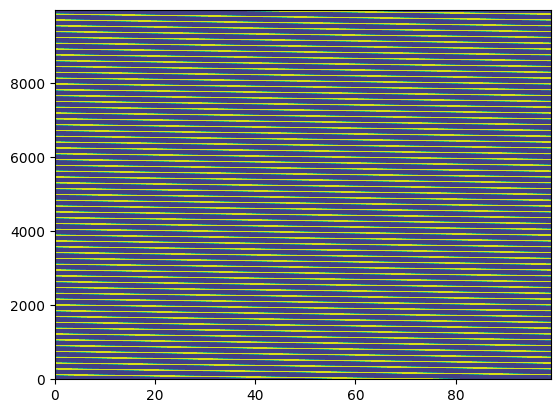

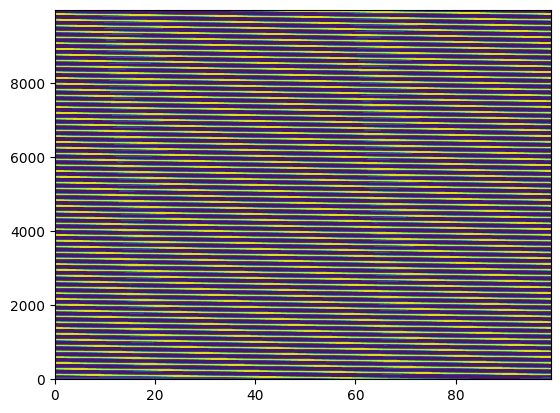

In [ ]:
plt.contourf(fft.irfft(true[:, 0, :]))
plt.show()

plt.contourf(fft.irfft(nudged[:, 0, :]))
plt.show()

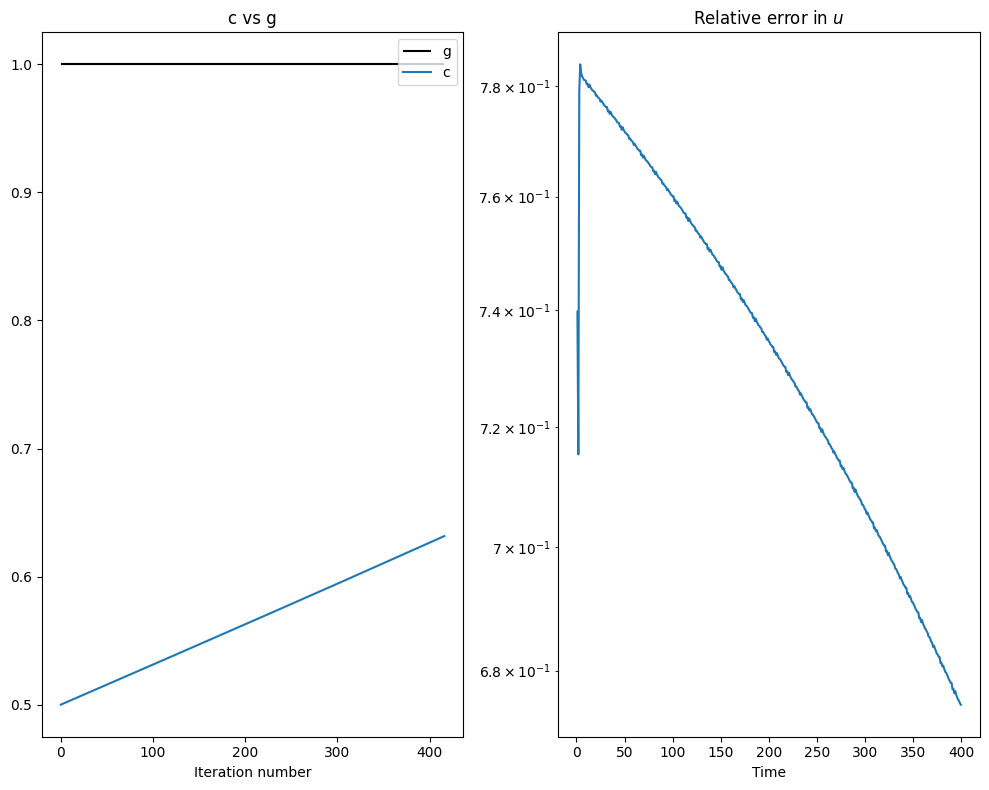

In [ ]:
fig, axs = plot(cs.T[0].real, u_errors, g, tls)
plt.show()